In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import dxchange
import glob
from enum import Enum

from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, HTML
import h5py
import pandas as pd

import matplotlib.patches as patches
from scipy.constants import h, c, electron_volt, m_n

In [2]:
sample_run_number = "8702"
ipts = "36063"

In [3]:
class TimeUnitOptions(str, Enum):
    s = "s"
    ms = "ms"
    us = "us"
    ns = "ns"
    ps = "ps"


class DistanceUnitOptions(str, Enum):
    cm = "cm"
    nm = "nm"
    pm = "pm"
    m = "m"
    angstrom = "angstrom"

def convert_time_units(from_unit, to_unit):
    """Convert time from one unit to another unit
    based on TimeUnitOptions options

    Args:
        from_unit (TimeUnitOptions): Unit to convert from.
        to_unit (TimeUnitOptions): Unit to convert to.

    Returns:
        float: Time in the new unit.
    """

    # Conversion factors
    conversion_factors = {
        TimeUnitOptions.s: 1,
        TimeUnitOptions.ms: 1e-3,
        TimeUnitOptions.us: 1e-6,
        TimeUnitOptions.ns: 1e-9,
        TimeUnitOptions.ps: 1e-12,
    }

    return conversion_factors[from_unit] / conversion_factors[to_unit]

def convert_distance_units(from_unit, to_unit):
    """Convert distance from one unit to another unit
    based on DistanceUnitOptions options

    Args:
        from_unit (DistanceUnitOptions): Unit to convert from.
        to_unit (DistanceUnitOptions): Unit to convert to.

    Returns:
        float: distance in the new unit.
    """

    # Conversion factors
    conversion_factors = {
        DistanceUnitOptions.nm: 1e-9,
        DistanceUnitOptions.cm: 1e-2,
        DistanceUnitOptions.pm: 1e-12,
        DistanceUnitOptions.m: 1,
        DistanceUnitOptions.angstrom: 1e-10,
    }

    return conversion_factors[from_unit] / conversion_factors[to_unit]

def convert_array_from_time_to_lambda(time_array: np.ndarray, 
                                      time_unit: TimeUnitOptions,       
                                      distance_source_detector: float,
                                      distance_source_detector_unit: DistanceUnitOptions,
                                      detector_offset: float,   
                                      detector_offset_unit: DistanceUnitOptions,
                                      lambda_unit: DistanceUnitOptions) -> np.ndarray:
    """Convert an array of time values to wavelength values.

    Args:
        time_array (np.ndarray): Array of time values.
        time_unit (TimeUnitOptions): Unit of the input time.
        distance_source_detector (float): Distance from the source to the detector.
        distance_source_detector_unit (DistanceUnitOptions): Unit of the distance.
        detector_offset (float): Offset of the detector.
        detector_offset_unit (DistanceUnitOptions): Unit of the offset.
        lambda_unit (DistanceUnitOptions): Unit of the output wavelength.

    This is using the formula: lambda_m = h/(m_n * distance_source_detector_m) * (time_array_s + detector_offset_s)

    Returns:
        np.ndarray: Array of wavelength values.
    """
    time_array_s = time_array * convert_time_units(time_unit, TimeUnitOptions.s)
    detector_offset_s = detector_offset * convert_time_units(detector_offset_unit, TimeUnitOptions.s)
    distance_source_detector_m = distance_source_detector * convert_distance_units(distance_source_detector_unit, DistanceUnitOptions.m)

    h_over_mn = h / m_n
    lambda_m = h_over_mn * (time_array_s + detector_offset_s) / distance_source_detector_m

    lambda_converted = lambda_m * convert_distance_units(DistanceUnitOptions.m, lambda_unit)

    return lambda_converted

# load the data

In [4]:
# load the data
sample_full_path = f"/SNS/VENUS/IPTS-{ipts}/shared/autoreduce/mcp/images/Run_{sample_run_number}/"
assert os.path.exists(sample_full_path), f"Path {sample_full_path} does not exist"

# spectra file
spectra_file_list = glob.glob(f"/SNS/VENUS/IPTS-{ipts}/shared/autoreduce/mcp/images/Run_{sample_run_number}/*_Spectra.txt")
if len(spectra_file_list) == 0:
    raise FileNotFoundError(f"No spectra files found in {sample_full_path}")
spectra_file = spectra_file_list[0]
display(HTML("Spectra file: " + spectra_file))

# nexus file
nexus_file = f"/SNS/VENUS/IPTS-{ipts}/nexus/VENUS_{sample_run_number}.nxs.h5"
assert os.path.exists(nexus_file), f"Path {nexus_file} does not exist"

In [5]:
list_tiff = glob.glob(os.path.join(sample_full_path, "*.tif"))
list_tiff.sort()
assert len(list_tiff) > 0, f"No tiff files found in {sample_full_path}"

In [6]:
# load the first tiff file
data_0 = dxchange.read_tiff(list_tiff[0])

# set up array
data = np.zeros((len(list_tiff), data_0.shape[0], data_0.shape[1]), dtype=data_0.dtype)
for i, _tif in enumerate(list_tiff):
    data[i] = dxchange.read_tiff(_tif)

In [7]:
# load from nexus
def get_detector_offset_from_nexus(nexus_path: str) -> float:
    """get the detector offset from the nexus file"""
    with h5py.File(nexus_path, 'r') as hdf5_data:
        try:
            detector_offset_micros = hdf5_data['entry']['DASlogs']['BL10:Det:TH:DSPT1:TIDelay']['value'][0]
        except KeyError:
            detector_offset_micros = None
    return detector_offset_micros

detector_offset_us = get_detector_offset_from_nexus(nexus_file)

# load the spectra
pd_spectra = pd.read_csv(spectra_file, sep=",", header=0)
shutter_time = pd_spectra["shutter_time"].values



Text(0.5, 1.0, 'Integrated data from run 8702')

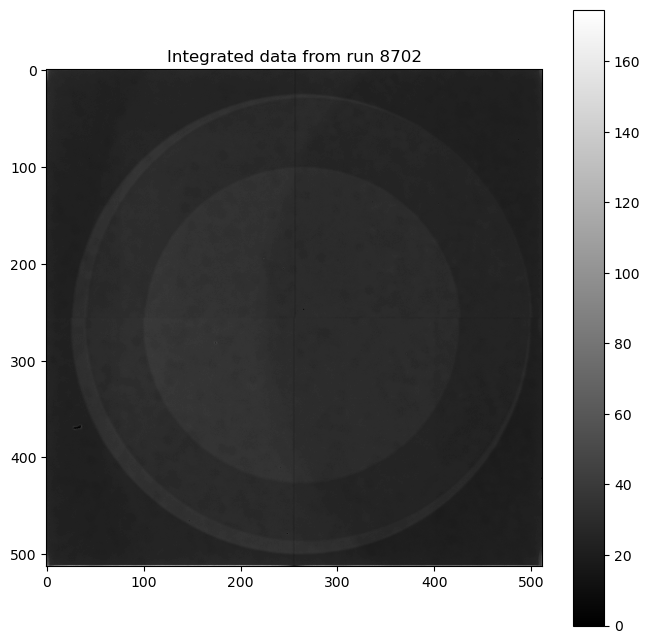

In [8]:
data_integrated = np.mean(data, axis=0)
fig, ax = plt.subplots(1,1, figsize=(8, 8))
im = ax.imshow(data_integrated, cmap='gray')
plt.colorbar(im, ax=ax)
ax.set_title(f"Integrated data from run {sample_run_number}")

# display profile of particular region

In [9]:
# select a region of interest
x0, x1 = 0, 500
y0, y1 = 200, 205

integrated_sample = np.mean(data, axis=0)

def plot_roi(x, y, width, height):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    im = ax.imshow(integrated_sample, cmap='gray')
    _rectangle1 = patches.Rectangle((x, y),
                                    width,
                                    height,
                                    edgecolor='red',
                                    linewidth=2,
                                    fill=False)
    ax.add_patch(_rectangle1)

    plt.colorbar(im, ax=ax)
    ax.set_title(f"ROI from x:{x} y:{y} width:{width} height:{height}")

    return x, y, width, height

display_plot_roi = interactive(plot_roi, 
                               x=widgets.IntSlider(min=0, max=data_integrated.shape[1], step=1, value=x0),
                               y=widgets.IntSlider(min=0, max=data_integrated.shape[1], step=1, value=x1),
                               width=widgets.IntSlider(min=0, max=data_integrated.shape[0], step=1, value=y0),
                               height=widgets.IntSlider(min=0, max=data_integrated.shape[0], step=1, value=y1))

display(display_plot_roi)

interactive(children=(IntSlider(value=0, description='x', max=512), IntSlider(value=500, description='y', max=…

Text(0, 0.5, 'Mean counts')

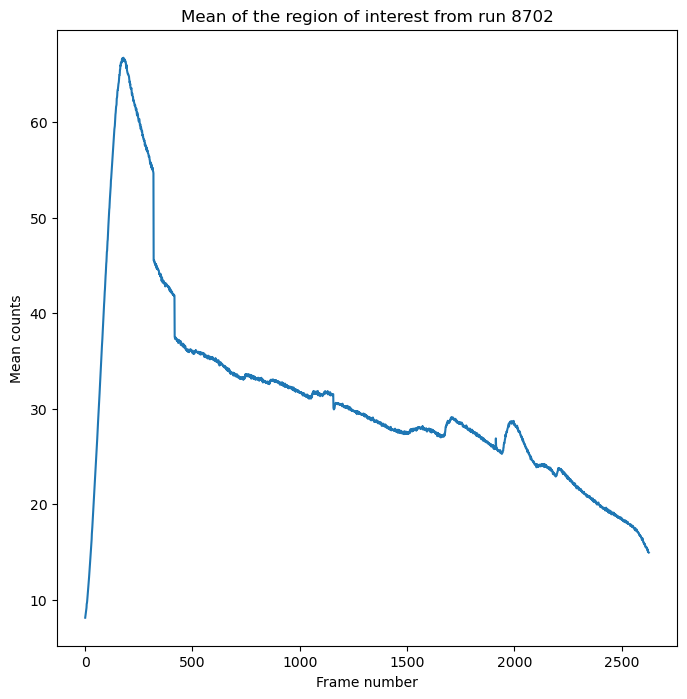

In [11]:
x,y,width,height = display_plot_roi.result

profile_of_region = []
for _data in data:
    # calculate the mean of the region of interest
    profile_of_region.append(np.mean(_data[y:y+height, x:x+width]))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(profile_of_region)
ax.set_title(f"Mean of the region of interest from run {sample_run_number}")
ax.set_xlabel("Frame number")
ax.set_ylabel("Mean counts")




In [12]:
lambda_axis = convert_array_from_time_to_lambda(time_array=shutter_time,
                                                time_unit=TimeUnitOptions.s,
                                                distance_source_detector=25,
                                                distance_source_detector_unit=DistanceUnitOptions.m,
                                                detector_offset=detector_offset_us,
                                                detector_offset_unit=TimeUnitOptions.us,
                                                lambda_unit=DistanceUnitOptions.angstrom)

Text(0, 0.5, 'Mean counts')

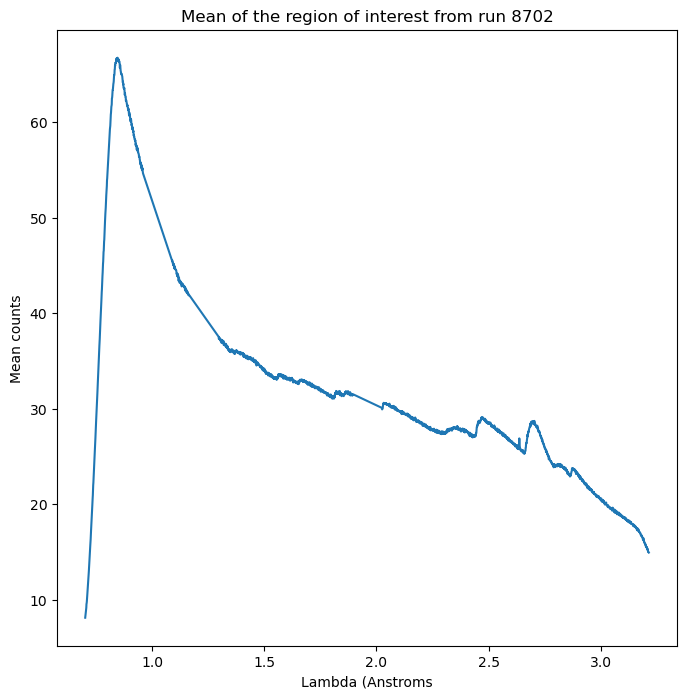

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(lambda_axis, profile_of_region)
ax.set_title(f"Mean of the region of interest from run {sample_run_number}")
ax.set_xlabel("Lambda (Anstroms")
ax.set_ylabel("Mean counts")